## Imports

In [1]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

%matplotlib inline

## GPU selection (for non Google Colab)
Uncomment the following line and change the index of GPU you want to use. 
Indeces start from '0'. You should only use one GPU for this project.


In [2]:
# os.environ['CUDA_VISIBLE_DEVICES']='0'

## Load data (for Google Colab only)
If you are using google colab, these codes help you easily load data.

**Rememeber to change runtime type to GPU if you are using google colab.**

Please store the dataset floder ([data](https://drive.google.com/drive/folders/1_0Doj4SmfqSNSm9CeMqNlagfb4APLQfq?usp=sharing)) to the root of your google drive first.
Then uncomment the codes, run them and follow the instruction to mount your google drive.

In [3]:
1assert os.environ['COLAB_GPU'] #'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then link the `data` in google drive to `./data`

In [4]:
!rm -f data
!ln -s '/content/drive/My Drive/data' data

## Some utilities

In [5]:
def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes2 = to_2d_tensor(boxes2)
    boxes2 = xywh_to_x1y1x2y2(boxes2)
    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, theta=0.75):
    IoU = compute_IoU(preds.clone(), targets.clone())
    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        
def box_to_mask(box, im_size):
    mask = np.zeros(im_size)
    co = xywh_to_x1y1x2y2(box)[0].type(torch.int64)
    mask[co[0]: co[2], co[1]: co[3]] = 1
    return Image.fromarray(np.uint8(mask*255).T)

def mask_to_box(mask):
    mask = torch.nonzero(mask[0, :, :].T != 0, as_tuple=False)
    x1, y1 = torch.min(mask, dim=0).values
    x2, y2 = torch.max(mask, dim=0).values
    return x1y1x2y2_to_xywh([x1, y1, x2, y2])[0]
    

## Split dataset

In [6]:
def split(ratio):
    with open('data/train_test_split.txt') as f:
        lines = f.read().splitlines()
    class_groups = dict()
    train_id, test_id = [], []
    for line in lines:
        key, is_train = line.split(' ')
        if is_train == '1':
            train_id.append(key)
        else:
            test_id.append(key)
    with open('data/images.txt') as f:
        lines = f.read().splitlines()
    for line in lines:
        value, line = line.split(' ', 1)
        key = line.split('.', 1)[0]
        if value not in train_id:
            continue
        if key in class_groups:
            class_groups[key].append(value)
        else:
            class_groups[key] = [value]
    val_id = []
    for _, group in class_groups.items():
        val_id.extend(random.sample(group, int(math.ceil(len(group)*ratio))))
    train_id = [i for i in train_id if i not in val_id]
    return np.array(train_id), np.array(test_id), np.array(val_id)

## Define Dataset

In [7]:
class CUBDataset(Dataset):
    def __init__(self, im_ids, transform=None):
        with open('data/images.txt') as f:
            id_to_path = dict([l.split(' ', 1) for l in f.read().splitlines()])
        with open('data/bounding_boxes.txt') as f:
            id_to_box = dict()
            for line in f.read().splitlines():
                im_id, *box = line.split(' ')
                id_to_box[im_id] = list(map(float, box))
        self.imgs = [(os.path.join('data/images', id_to_path[i]), id_to_box[i])
                     for i in im_ids]
        self.target_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.transform = transforms.Compose([
            self.target_transform,
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        if transform is not None:
            self.transform = transforms.Compose([
                transform,
                self.transform
            ])
            self.target_transform = transforms.Compose([
                transform,
                self.target_transform
            ])
            
    def __getitem__(self, index):
        path, box = self.imgs[index]
        im = Image.open(path).convert('RGB')
        im_size = np.array(im.size, dtype='float32')
        box = np.array(box, dtype='float32')
        
        mask = box_to_mask(box, im.size)
        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        im = self.transform(im)
        
        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.target_transform(mask)
        
        box = mask_to_box(mask).numpy()

        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        
        return im, box
    
    def __len__(self):
        return len(self.imgs)
    

### Visualize training data

In [8]:
def imshow(img, gt_box, pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, color='red'):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        plt.gca().add_patch(
            plt.Rectangle((x, y), w, h,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
        
    draw_box(gt_box)
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

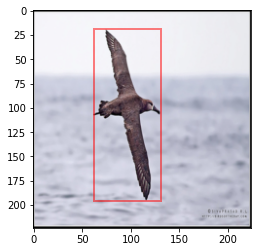

In [9]:
dataset = CUBDataset(['2'])
im, box = dataset[0]

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(inp, box)

### Visualize result of output
If you need, this function can help you compare the result of your model and the ground truth.

In [10]:
def visualize_model(model, datasets):
    model = model.cpu()
    ind = random.choice(range(len(datasets['test'])))
    im, box = datasets['test'][ind]
    path, _ = datasets['test'].imgs[ind]

    pred_box = model(Variable(im.unsqueeze(0))).data[0]

    ori_im = Image.open(path)

    inp = im.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    box = box_transform_inv(box_transform(box, inp.shape[:2][::-1]), ori_im.size)[0]
    pred_box = box_transform_inv(box_transform(pred_box, inp.shape[:2][::-1]), ori_im.size)[0]
    imshow(ori_im, box, pred_box)

In [11]:
def plot(epoch_loss, epoch_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
    ax1.set_yscale('log')
    for phase in ('train', 'test'):
        ax1.plot(range(len(epoch_loss[phase])), epoch_loss[phase], label=(phase + '_loss'))
        ax2.plot(range(len(epoch_acc[phase])), epoch_acc[phase], label=(phase + '_acc'))
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})

### Training Function

In [12]:
def train(model, dataloaders, optimizer, save_name=None, quite=False):
    # prepare data
    # construct model
    model = model.cuda()

    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_model_state = model.state_dict()
    best_epoch = -1
    best_acc = 0.0

    epoch_loss = {'train': [], 'test': [], 'val': []}
    epoch_acc = {'train': [], 'test': [], 'val': []}
    epochs = 20
    for epoch in range(epochs):
        accs = AverageMeter()
        losses = AverageMeter()
        for phase in dataloaders.keys():
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            end = time.time()
            for ims, boxes in tqdm(dataloaders[phase], desc=f'[{phase} {epoch+1}/{epochs}]', leave=False):
                inputs = Variable(ims.cuda())
                targets = Variable(boxes.cuda())
                
                loss, outputs = do_one_step(model, inputs, targets, optimizer, phase)
                
                acc = compute_acc(outputs.data.cpu(), targets.data.cpu())

                nsample = inputs.size(0)
                accs.update(acc, nsample)
                losses.update(loss.item(), nsample)

            if phase == 'val' and accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()
            elif phase == 'train':
                scheduler.step()
            elapsed_time = time.time() - end
            if not quite:
                print(f'[{phase}]\tEpoch: {epoch+1}/{epochs}'+
                    f'\tLoss: {losses.avg:.4f}\tAcc: {accs.avg:.2%}\tTime: {elapsed_time:.3f}')
            epoch_loss[phase].append(losses.avg)
            epoch_acc[phase].append(accs.avg)

    print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')
    if save_name is not None:
        torch.save(best_model_state, save_name)
        print(f'[Info] best model saved to {save_name}')
    return epoch_loss, epoch_acc

## Task1
In this task, you are required to load ImageNet-pretrained `ResNet-18` and modify the fully connected layer to output the bounding box.

In [13]:
def get_model():
    model = models.resnet18(pretrained=True)
    ### TODO: modify model here
    num_in = model.fc.in_features
    model.fc = nn.Linear(num_in, 4)
    return model

In [14]:
### print the model
print(get_model())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

## Task2

In this task, you are required to define the `huber` loss function. It's defined as:
$$\mathcal{L}(\mathbf{a}, \mathbf{b}) = \frac{1}{n}\sum_{i=1}^n\begin{cases}0.5(a_i-b_i)^2 & \text{if } |a_i-b_i|<1\\|a_i-b_i|-0.5 & \text{otherwise}\end{cases}$$

Input parameters of the function may have different shapes, but you can view inputs as two vectors.

Please notice that you _SHAN'T_ use for loop in python.

In [15]:
def huber(a, b):
    ### TODO: implment smooth l1 loss here
    tot = torch.abs(a - b)
    huber = (((tot[tot < 1])**2) * 0.5).sum()
    huber += (tot[tot >= 1] - 0.5).sum()
    huber = 1/(len(a)) * huber
    return huber

Please test your `huber` here to ensure it works properly. You can try different `a` and `b` with different shapes.

In [16]:
### Test huber here.
assert torch.equal(huber(torch.tensor([1, 2]), torch.tensor([1, 2.5])), torch.tensor(0.0625))
### TODO: more assert check here...
assert torch.equal(huber(torch.tensor([-0.3, 2, -1.3]), torch.tensor([0.5, 0.8, -0.2])), torch.tensor(0.54))

### Summary
_Write your report here_

## Task3

In this task, you are required to define the `do_one_step` function and simply train the model you modified on CUB dataset. This function will be called in the pre-defined `train` function.

Define your `do_one_step` function here. In this function, please use your `huber` function here.

Parameters are:
- `model`: the model
- `inputs`: a batch of images as inputs
- `targets`: a batch of labels as targets (ground truth)
- `optimizer`: the algorithm to optimize the model
- `phase`: `train` or `test` or `val`

Returns are:
- `loss`: the loss of the batch
- `outputs`: the outputs of the model

Notice that you ONLY have to update the model in `train` phase. But you have to always output the `loss` and `outputs`.

In [17]:
def do_one_step(model, inputs, targets, optimizer, phase):
    ### TODO
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = huber(outputs, targets)
    loss.backward()
    if phase == 'train':
      optimizer.step()
    return loss, outputs

Then you can try to train the model based on your `do_one_step` function.

Please use `SGD` with `momentum=0.9` and `learing rate=0.001` as the optmizer. (The rest tasks also use the same configuration)

In [18]:
### split the dataset using offical splits and take 10% of the training set as the validation set
train_id, test_id, val_id = split(0.1)

### define the datasets using the splits
splits = {'train': train_id, 'test': test_id, 'val': val_id}
datasets = {k: CUBDataset(v) for k, v in splits.items()}

### define dataloaders from the datasets
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in datasets.items()}

model = get_model()

### TODO: SGD here 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### weights are automatically saved after training
pure_epoch_loss, pure_epoch_acc = train(model, dataloaders, optimizer, 'pure.tar')
np.savez('pure.npz', epoch_loss=pure_epoch_loss, epoch_acc=pure_epoch_acc)

[train]	Epoch: 1/20	Loss: 114.6602	Acc: 10.94%	Time: 738.561


[test]	Epoch: 1/20	Loss: 93.3698	Acc: 15.36%	Time: 713.476


[val]	Epoch: 1/20	Loss: 92.3007	Acc: 15.61%	Time: 78.562


[train]	Epoch: 2/20	Loss: 50.3603	Acc: 41.21%	Time: 54.019


[test]	Epoch: 2/20	Loss: 46.3818	Acc: 46.70%	Time: 58.357


[val]	Epoch: 2/20	Loss: 46.2157	Acc: 46.90%	Time: 6.398


[train]	Epoch: 3/20	Loss: 38.3825	Acc: 59.94%	Time: 55.100


[test]	Epoch: 3/20	Loss: 39.3916	Acc: 58.85%	Time: 58.101


[val]	Epoch: 3/20	Loss: 39.4669	Acc: 58.85%	Time: 6.224


[train]	Epoch: 4/20	Loss: 34.0393	Acc: 65.44%	Time: 54.496


[test]	Epoch: 4/20	Loss: 37.5675	Acc: 63.69%	Time: 60.281


[val]	Epoch: 4/20	Loss: 37.7063	Acc: 63.66%	Time: 6.490


[train]	Epoch: 5/20	Loss: 30.0395	Acc: 72.69%	Time: 56.074


[test]	Epoch: 5/20	Loss: 31.5443	Acc: 69.60%	Time: 59.817


[val]	Epoch: 5/20	Loss: 31.6421	Acc: 69.38%	Time: 6.452


[train]	Epoch: 6/20	Loss: 23.3675	Acc: 82.80%	Time: 55.610


[test]	Epoch: 6/20	Loss: 23.9352	Acc: 82.36%	Time: 59.357


[val]	Epoch: 6/20	Loss: 24.0033	Acc: 82.37%	Time: 6.483


[train]	Epoch: 7/20	Loss: 21.5781	Acc: 86.36%	Time: 55.784


[test]	Epoch: 7/20	Loss: 22.7922	Acc: 84.49%	Time: 59.597


[val]	Epoch: 7/20	Loss: 22.8856	Acc: 84.39%	Time: 6.398


[train]	Epoch: 8/20	Loss: 20.9599	Acc: 86.65%	Time: 56.202


[test]	Epoch: 8/20	Loss: 22.4067	Acc: 84.88%	Time: 58.254


[val]	Epoch: 8/20	Loss: 22.5114	Acc: 84.83%	Time: 6.373


[train]	Epoch: 9/20	Loss: 19.8714	Acc: 87.75%	Time: 54.564


[test]	Epoch: 9/20	Loss: 21.9022	Acc: 85.43%	Time: 58.958


[val]	Epoch: 9/20	Loss: 22.0380	Acc: 85.35%	Time: 6.255


[train]	Epoch: 10/20	Loss: 18.9284	Acc: 89.23%	Time: 55.189


[test]	Epoch: 10/20	Loss: 21.1792	Acc: 86.33%	Time: 58.970


[val]	Epoch: 10/20	Loss: 21.3340	Acc: 86.19%	Time: 6.295


[train]	Epoch: 11/20	Loss: 19.0735	Acc: 88.84%	Time: 54.728


[test]	Epoch: 11/20	Loss: 21.3244	Acc: 86.14%	Time: 58.238


[val]	Epoch: 11/20	Loss: 21.4763	Acc: 86.02%	Time: 6.241


[train]	Epoch: 12/20	Loss: 18.6149	Acc: 90.16%	Time: 54.497


[test]	Epoch: 12/20	Loss: 20.9723	Acc: 86.83%	Time: 57.687


[val]	Epoch: 12/20	Loss: 21.1239	Acc: 86.67%	Time: 6.264


[train]	Epoch: 13/20	Loss: 19.0208	Acc: 89.51%	Time: 54.331


[test]	Epoch: 13/20	Loss: 21.2625	Acc: 86.56%	Time: 58.535


[val]	Epoch: 13/20	Loss: 21.4059	Acc: 86.41%	Time: 6.237


[train]	Epoch: 14/20	Loss: 17.8416	Acc: 90.77%	Time: 55.405


[test]	Epoch: 14/20	Loss: 20.5740	Acc: 87.29%	Time: 59.077


[val]	Epoch: 14/20	Loss: 20.7447	Acc: 87.11%	Time: 6.427


[train]	Epoch: 15/20	Loss: 18.7787	Acc: 89.64%	Time: 55.793


[test]	Epoch: 15/20	Loss: 21.3137	Acc: 86.15%	Time: 59.493


[val]	Epoch: 15/20	Loss: 21.4779	Acc: 86.01%	Time: 6.383


[train]	Epoch: 16/20	Loss: 18.3235	Acc: 90.80%	Time: 55.704


[test]	Epoch: 16/20	Loss: 20.8778	Acc: 87.29%	Time: 59.215


[val]	Epoch: 16/20	Loss: 21.0481	Acc: 87.10%	Time: 6.454


[train]	Epoch: 17/20	Loss: 17.7666	Acc: 90.80%	Time: 55.882


[test]	Epoch: 17/20	Loss: 20.5067	Acc: 87.25%	Time: 60.147


[val]	Epoch: 17/20	Loss: 20.6725	Acc: 87.07%	Time: 6.502


[train]	Epoch: 18/20	Loss: 18.3527	Acc: 90.04%	Time: 57.117


[test]	Epoch: 18/20	Loss: 20.8326	Acc: 86.81%	Time: 59.965


[val]	Epoch: 18/20	Loss: 20.9872	Acc: 86.66%	Time: 6.429


[train]	Epoch: 19/20	Loss: 18.6085	Acc: 90.64%	Time: 55.358


[test]	Epoch: 19/20	Loss: 21.2177	Acc: 86.76%	Time: 59.350


[val]	Epoch: 19/20	Loss: 21.3799	Acc: 86.56%	Time: 6.412


[train]	Epoch: 20/20	Loss: 18.4140	Acc: 90.04%	Time: 55.865


[test]	Epoch: 20/20	Loss: 20.9981	Acc: 86.83%	Time: 59.052


[val]	Epoch: 20/20	Loss: 21.1626	Acc: 86.66%	Time: 6.560
[Info] best val acc: 87.11% at 14th epoch
[Info] best model saved to pure.tar


Plot the cruve.

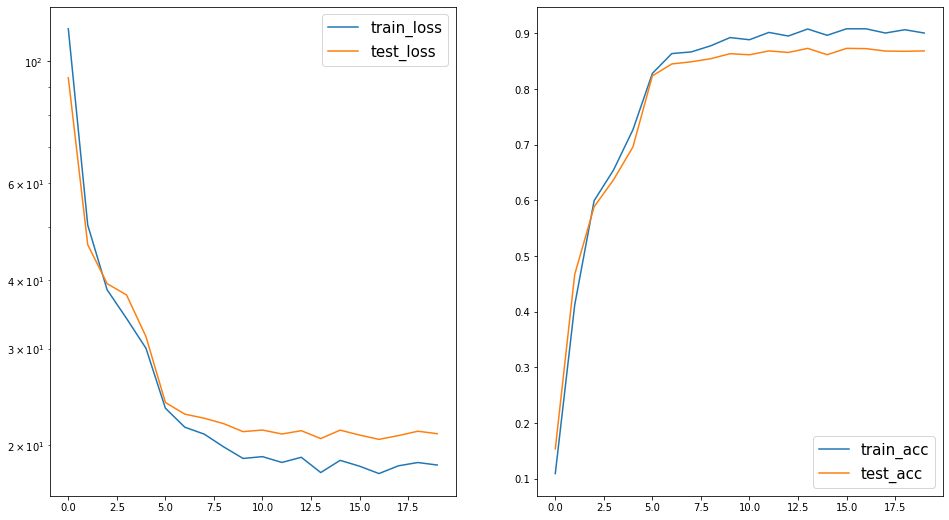

In [19]:
plot(pure_epoch_loss, pure_epoch_acc)

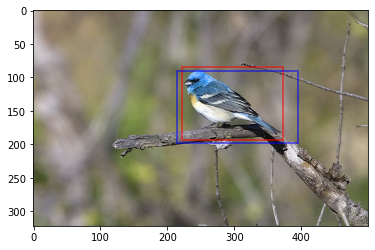

In [20]:
### if needed, you can also visualize one test sample by the trained model
visualize_model(model, datasets)

### Summary
We can see from the plot that those the maximum accuracy is reached at the 14th epoch, then it will go lower again, the same occur to the loss as well. This may be caused by over fitting thus lowering the model performance.

## Task4

In this tasks, you are required to add L2-regularization to the loss. In pytorch, you can easily implement it by setting one parameter of the optimizer. You need to find the best regularization parameter $\alpha$ using 3-fold cross-validation. So in this task, you need to impliment your own splits. You can use `KFold` in sci-learn which is already included.

In [21]:
### TODO: implement your own split.
###       You can use `split(0)` to get the whole training set and testing set first.
###       `yield` maybe helpful.
###       You can use `KFold` from sklearn.

def three_fold_split():
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    k_train, k_test, k_val = split(0)
    for k_trainid, k_valid in kf.split(k_train):
        train = k_train[k_trainid]
        val = k_train[k_valid]
    yield train, k_test, val
    pass

# TODO: Define your candidates 
alphas = [0.000005, 0.00001, 0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.01, 0.03, 0.1] 
best_alpha = 0
best_acc = 0

for alpha in alphas:
    avg_acc = 0
    
    for train_id, test_id, val_id in three_fold_split():
        ### define the datasets using the splits. test is uselss here so omitted.
        splits = {'train': train_id, 'val': val_id}
        datasets = {k: CUBDataset(v) for k, v in splits.items()}

        ### define dataloaders from the datasets
        dataloaders = {k: torch.utils.data.DataLoader(
                        v, batch_size=32, shuffle=(k=='train'),
                        num_workers=2, pin_memory=True) for k, v in datasets.items()}

        model = get_model()

        ### TODO: use the alpha
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=alpha)
        ### quitely train
        epoch_loss, epoch_acc = train(model, dataloaders, optimizer, quite=True)
        
        avg_acc += np.max(epoch_acc['val'])/3

    print(f'[alpha={alpha}] avg_acc={avg_acc}')

    if best_acc < avg_acc:
        best_alpha = alpha
        best_acc = avg_acc

print(f'best_alpha={best_alpha}')        

### After got the best alpha, train model again over the original splits
train_id, test_id, val_id = split(0.1)
splits = {'train': train_id, 'test': test_id, 'val': val_id}
datasets = {k: CUBDataset(v) for k, v in splits.items()}
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in datasets.items()}
model = get_model()

### TODO: use the best alpha
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=best_alpha)

### weights are automatically saved after training
l2_epoch_loss, l2_epoch_acc = train(model, dataloaders, optimizer, 'l2.tar')
np.savez('l2.npz', epoch_loss=l2_epoch_loss, epoch_acc=l2_epoch_acc)

[Info] best val acc: 85.84% at 12th epoch
[alpha=5e-06] avg_acc=0.28611945278611944


[Info] best val acc: 87.20% at 18th epoch
[alpha=1e-05] avg_acc=0.29067956845734627


[Info] best val acc: 86.44% at 18th epoch
[alpha=0.0001] avg_acc=0.28812145478812146


[Info] best val acc: 86.27% at 20th epoch
[alpha=0.0003] avg_acc=0.2875653431208987


[Info] best val acc: 86.59% at 17th epoch
[alpha=0.0005] avg_acc=0.28862195528862195


[Info] best val acc: 86.64% at 16th epoch
[alpha=0.001] avg_acc=0.2887887887887888


[Info] best val acc: 86.14% at 17th epoch
[alpha=0.003] avg_acc=0.2871204537871204


[Info] best val acc: 86.42% at 18th epoch
[alpha=0.01] avg_acc=0.28806584362139914


[Info] best val acc: 84.93% at 20th epoch
[alpha=0.03] avg_acc=0.28311644978311645


[Info] best val acc: 80.48% at 17th epoch
[alpha=0.1] avg_acc=0.2682682682682683
best_alpha=1e-05


[train]	Epoch: 1/20	Loss: 120.1489	Acc: 7.95%	Time: 60.758


[test]	Epoch: 1/20	Loss: 92.7843	Acc: 16.02%	Time: 65.112


[val]	Epoch: 1/20	Loss: 91.6022	Acc: 16.34%	Time: 6.988


[train]	Epoch: 2/20	Loss: 54.0070	Acc: 36.65%	Time: 60.928


[test]	Epoch: 2/20	Loss: 50.2054	Acc: 39.19%	Time: 65.301


[val]	Epoch: 2/20	Loss: 50.0877	Acc: 39.25%	Time: 6.997


[train]	Epoch: 3/20	Loss: 40.6002	Acc: 56.79%	Time: 61.143


[test]	Epoch: 3/20	Loss: 39.2529	Acc: 58.22%	Time: 64.928


[val]	Epoch: 3/20	Loss: 39.2977	Acc: 58.19%	Time: 7.053


[train]	Epoch: 4/20	Loss: 34.5360	Acc: 65.07%	Time: 60.889


[test]	Epoch: 4/20	Loss: 35.3096	Acc: 65.61%	Time: 65.245


[val]	Epoch: 4/20	Loss: 35.4059	Acc: 65.62%	Time: 7.157


[train]	Epoch: 5/20	Loss: 30.4450	Acc: 71.95%	Time: 61.179


[test]	Epoch: 5/20	Loss: 30.9929	Acc: 71.68%	Time: 65.581


[val]	Epoch: 5/20	Loss: 31.0564	Acc: 71.68%	Time: 7.147


[train]	Epoch: 6/20	Loss: 23.9751	Acc: 82.26%	Time: 61.272


[test]	Epoch: 6/20	Loss: 24.5854	Acc: 81.57%	Time: 65.624


[val]	Epoch: 6/20	Loss: 24.6442	Acc: 81.55%	Time: 7.167


[train]	Epoch: 7/20	Loss: 22.4111	Acc: 85.17%	Time: 61.614


[test]	Epoch: 7/20	Loss: 23.4528	Acc: 83.49%	Time: 65.582


[val]	Epoch: 7/20	Loss: 23.5264	Acc: 83.41%	Time: 7.048


[train]	Epoch: 8/20	Loss: 20.2787	Acc: 86.97%	Time: 61.137


[test]	Epoch: 8/20	Loss: 22.3982	Acc: 84.30%	Time: 66.400


[val]	Epoch: 8/20	Loss: 22.5274	Acc: 84.22%	Time: 7.235


[train]	Epoch: 9/20	Loss: 20.5413	Acc: 87.06%	Time: 62.377


[test]	Epoch: 9/20	Loss: 22.5739	Acc: 83.47%	Time: 65.800


[val]	Epoch: 9/20	Loss: 22.7041	Acc: 83.30%	Time: 7.134


[train]	Epoch: 10/20	Loss: 20.3334	Acc: 88.25%	Time: 61.195


[test]	Epoch: 10/20	Loss: 22.2601	Acc: 85.40%	Time: 66.746


[val]	Epoch: 10/20	Loss: 22.3770	Acc: 85.28%	Time: 7.239


[train]	Epoch: 11/20	Loss: 20.0025	Acc: 88.82%	Time: 62.502


[test]	Epoch: 11/20	Loss: 21.7853	Acc: 85.92%	Time: 66.490


[val]	Epoch: 11/20	Loss: 21.8969	Acc: 85.76%	Time: 7.229


[train]	Epoch: 12/20	Loss: 19.2449	Acc: 89.60%	Time: 62.706


[test]	Epoch: 12/20	Loss: 21.4541	Acc: 86.29%	Time: 66.462


[val]	Epoch: 12/20	Loss: 21.5884	Acc: 86.16%	Time: 7.194


[train]	Epoch: 13/20	Loss: 18.9961	Acc: 89.62%	Time: 61.824


[test]	Epoch: 13/20	Loss: 21.3066	Acc: 86.37%	Time: 65.929


[val]	Epoch: 13/20	Loss: 21.4469	Acc: 86.27%	Time: 7.117


[train]	Epoch: 14/20	Loss: 19.1281	Acc: 90.25%	Time: 62.454


[test]	Epoch: 14/20	Loss: 21.4351	Acc: 86.32%	Time: 66.832


[val]	Epoch: 14/20	Loss: 21.5741	Acc: 86.18%	Time: 7.135


[train]	Epoch: 15/20	Loss: 18.7201	Acc: 89.66%	Time: 62.731


[test]	Epoch: 15/20	Loss: 21.2502	Acc: 86.37%	Time: 66.885


[val]	Epoch: 15/20	Loss: 21.4018	Acc: 86.19%	Time: 7.157


[train]	Epoch: 16/20	Loss: 18.4745	Acc: 90.77%	Time: 62.441


[test]	Epoch: 16/20	Loss: 21.1108	Acc: 86.66%	Time: 66.763


[val]	Epoch: 16/20	Loss: 21.2628	Acc: 86.47%	Time: 7.184


[train]	Epoch: 17/20	Loss: 19.2339	Acc: 89.99%	Time: 62.236


[test]	Epoch: 17/20	Loss: 21.5432	Acc: 86.12%	Time: 67.088


[val]	Epoch: 17/20	Loss: 21.6797	Acc: 85.99%	Time: 7.214


[train]	Epoch: 18/20	Loss: 18.4511	Acc: 90.69%	Time: 62.290


[test]	Epoch: 18/20	Loss: 21.0404	Acc: 86.79%	Time: 66.065


[val]	Epoch: 18/20	Loss: 21.1912	Acc: 86.66%	Time: 7.000


[train]	Epoch: 19/20	Loss: 18.2818	Acc: 90.03%	Time: 61.788


[test]	Epoch: 19/20	Loss: 20.9538	Acc: 86.66%	Time: 67.039


[val]	Epoch: 19/20	Loss: 21.1071	Acc: 86.55%	Time: 7.199


[train]	Epoch: 20/20	Loss: 18.5996	Acc: 89.23%	Time: 62.441


[test]	Epoch: 20/20	Loss: 21.3540	Acc: 86.13%	Time: 67.220


[val]	Epoch: 20/20	Loss: 21.5120	Acc: 85.94%	Time: 7.216
[Info] best val acc: 86.66% at 18th epoch
[Info] best model saved to l2.tar


plot the curve

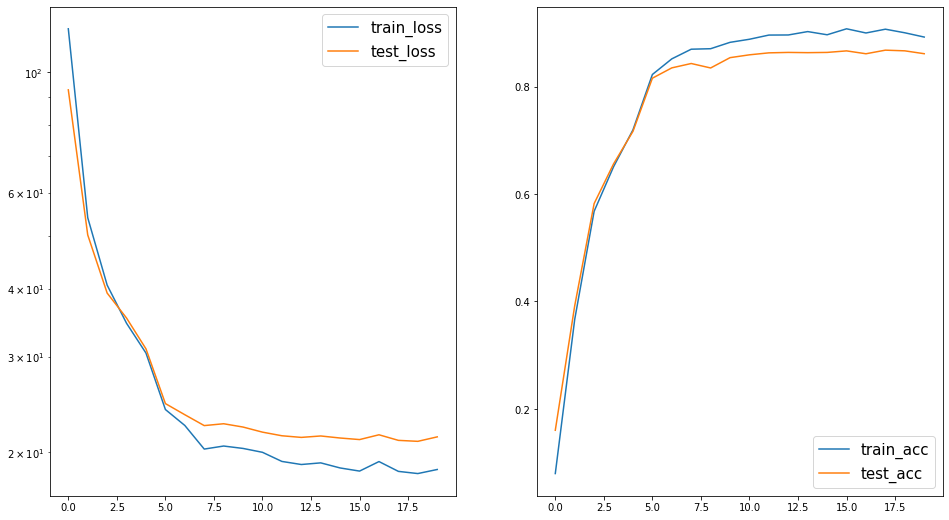

In [22]:
plot(l2_epoch_loss, l2_epoch_acc)

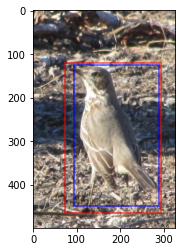

In [23]:
### if needed, you can also visualize one test sample by the trained model
visualize_model(model, datasets)

### Summary
In my opinion, finding the right value for alpha is crucial for the model performance. Also, I find using smaller alpha works better than larger ones. This may be explained by, since L2 regularization is used in order to avoid overfitting by making changes according to a given alpha to the original new weight, using alpha with big values might lead to underfitting.

## Task5

In this tasks, you are required to add data agumentation to the dataset. So you have to define your own transformers to the dataset.

In [24]:
train_id, test_id, val_id = split(0.1)

def get_transform(split):
    if split == 'train':
        return transforms.Compose([
            ### TODO: do your data augmentation here
            ###       you DONT have to resize and normalize the image
            transforms.ColorJitter(brightness=0.7, contrast=0.5, saturation=0.8, hue=0.35),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
        ])
    else:
        return None

splits = {'train': train_id, 'test': test_id, 'val': val_id}
datasets = {k: CUBDataset(v, transform=get_transform(k)) for k, v in splits.items()}

### define dataloaders from the datasets
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in datasets.items()}

model = get_model()

### TODO
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### weights are automatically saved after training
aug_epoch_loss, aug_epoch_acc = train(model, dataloaders, optimizer, 'augment.tar')
np.savez('augment.npz', epoch_loss=aug_epoch_loss, epoch_acc=aug_epoch_loss)

[train]	Epoch: 1/20	Loss: 153.1198	Acc: 26.05%	Time: 154.582


[test]	Epoch: 1/20	Loss: 170.2231	Acc: 14.38%	Time: 65.948


[val]	Epoch: 1/20	Loss: 170.9230	Acc: 13.81%	Time: 7.046


[train]	Epoch: 2/20	Loss: 97.6909	Acc: 40.86%	Time: 153.799


[test]	Epoch: 2/20	Loss: 184.7945	Acc: 21.14%	Time: 66.733


[val]	Epoch: 2/20	Loss: 188.7707	Acc: 20.20%	Time: 7.085


[train]	Epoch: 3/20	Loss: 92.7007	Acc: 42.49%	Time: 154.831


[test]	Epoch: 3/20	Loss: 121.7628	Acc: 23.20%	Time: 66.551


[val]	Epoch: 3/20	Loss: 122.9123	Acc: 22.26%	Time: 7.229


[train]	Epoch: 4/20	Loss: 88.8015	Acc: 43.83%	Time: 154.372


[test]	Epoch: 4/20	Loss: 157.0679	Acc: 23.68%	Time: 65.458


[val]	Epoch: 4/20	Loss: 160.1533	Acc: 22.73%	Time: 7.028


[train]	Epoch: 5/20	Loss: 87.2395	Acc: 43.99%	Time: 154.267


[test]	Epoch: 5/20	Loss: 149.8388	Acc: 23.44%	Time: 66.504


[val]	Epoch: 5/20	Loss: 152.8853	Acc: 22.45%	Time: 7.171


[train]	Epoch: 6/20	Loss: 80.3039	Acc: 45.79%	Time: 155.216


[test]	Epoch: 6/20	Loss: 134.9431	Acc: 25.16%	Time: 65.690


[val]	Epoch: 6/20	Loss: 137.5918	Acc: 24.19%	Time: 7.052


[train]	Epoch: 7/20	Loss: 78.2799	Acc: 45.44%	Time: 154.070


[test]	Epoch: 7/20	Loss: 136.2081	Acc: 24.95%	Time: 66.761


[val]	Epoch: 7/20	Loss: 139.0155	Acc: 23.91%	Time: 7.164


[train]	Epoch: 8/20	Loss: 77.6438	Acc: 45.75%	Time: 154.994


[test]	Epoch: 8/20	Loss: 135.0733	Acc: 25.55%	Time: 65.457


[val]	Epoch: 8/20	Loss: 137.8737	Acc: 24.53%	Time: 7.068


[train]	Epoch: 9/20	Loss: 77.3796	Acc: 46.07%	Time: 153.483


[test]	Epoch: 9/20	Loss: 125.6474	Acc: 25.83%	Time: 65.974


[val]	Epoch: 9/20	Loss: 127.9780	Acc: 24.80%	Time: 7.357


[train]	Epoch: 10/20	Loss: 75.6171	Acc: 46.53%	Time: 155.536


[test]	Epoch: 10/20	Loss: 127.7701	Acc: 26.30%	Time: 66.413


[val]	Epoch: 10/20	Loss: 130.3181	Acc: 25.30%	Time: 7.218


[train]	Epoch: 11/20	Loss: 73.9768	Acc: 47.26%	Time: 153.769


[test]	Epoch: 11/20	Loss: 121.2214	Acc: 27.03%	Time: 65.583


[val]	Epoch: 11/20	Loss: 123.5301	Acc: 25.98%	Time: 7.371


[train]	Epoch: 12/20	Loss: 74.2033	Acc: 46.51%	Time: 153.818


[test]	Epoch: 12/20	Loss: 119.7362	Acc: 26.79%	Time: 65.707


[val]	Epoch: 12/20	Loss: 121.9689	Acc: 25.71%	Time: 7.124


[train]	Epoch: 13/20	Loss: 74.2427	Acc: 46.66%	Time: 153.041


[test]	Epoch: 13/20	Loss: 118.8805	Acc: 26.90%	Time: 66.229


[val]	Epoch: 13/20	Loss: 121.0514	Acc: 25.84%	Time: 7.180


[train]	Epoch: 14/20	Loss: 75.0811	Acc: 46.59%	Time: 154.578


[test]	Epoch: 14/20	Loss: 122.9588	Acc: 26.53%	Time: 66.720


[val]	Epoch: 14/20	Loss: 125.3264	Acc: 25.48%	Time: 7.249


[train]	Epoch: 15/20	Loss: 72.8388	Acc: 47.22%	Time: 154.594


[test]	Epoch: 15/20	Loss: 120.1845	Acc: 26.94%	Time: 66.720


[val]	Epoch: 15/20	Loss: 122.5200	Acc: 25.91%	Time: 7.225


[train]	Epoch: 16/20	Loss: 74.2623	Acc: 47.26%	Time: 154.837


[test]	Epoch: 16/20	Loss: 119.7951	Acc: 27.14%	Time: 66.481


[val]	Epoch: 16/20	Loss: 122.0415	Acc: 26.08%	Time: 7.210


[train]	Epoch: 17/20	Loss: 71.7083	Acc: 47.46%	Time: 155.850


[test]	Epoch: 17/20	Loss: 120.5767	Acc: 27.06%	Time: 67.126


[val]	Epoch: 17/20	Loss: 122.9982	Acc: 25.98%	Time: 7.105


[train]	Epoch: 18/20	Loss: 75.6510	Acc: 46.51%	Time: 154.252


[test]	Epoch: 18/20	Loss: 121.4414	Acc: 26.68%	Time: 66.471


[val]	Epoch: 18/20	Loss: 123.7018	Acc: 25.63%	Time: 7.205


[train]	Epoch: 19/20	Loss: 73.4024	Acc: 47.09%	Time: 155.410


[test]	Epoch: 19/20	Loss: 118.6494	Acc: 27.10%	Time: 66.140


[val]	Epoch: 19/20	Loss: 120.8858	Acc: 26.03%	Time: 7.208


[train]	Epoch: 20/20	Loss: 73.4560	Acc: 46.83%	Time: 156.731


[test]	Epoch: 20/20	Loss: 120.3978	Acc: 26.92%	Time: 66.588


[val]	Epoch: 20/20	Loss: 122.7159	Acc: 25.87%	Time: 7.222
[Info] best val acc: 26.08% at 16th epoch
[Info] best model saved to augment.tar


plot the curve

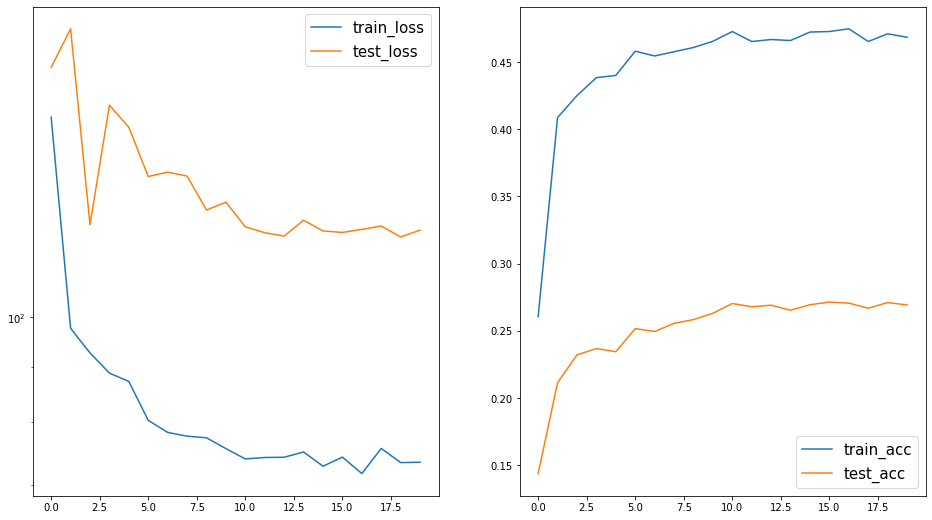

In [38]:
plot(aug_epoch_loss, aug_epoch_acc)

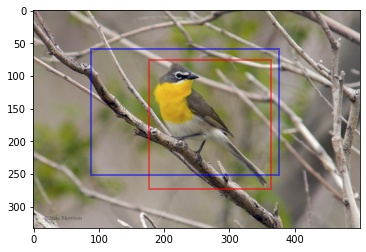

In [26]:
### if needed, you can also visualize one test sample by the trained model
visualize_model(model, datasets)

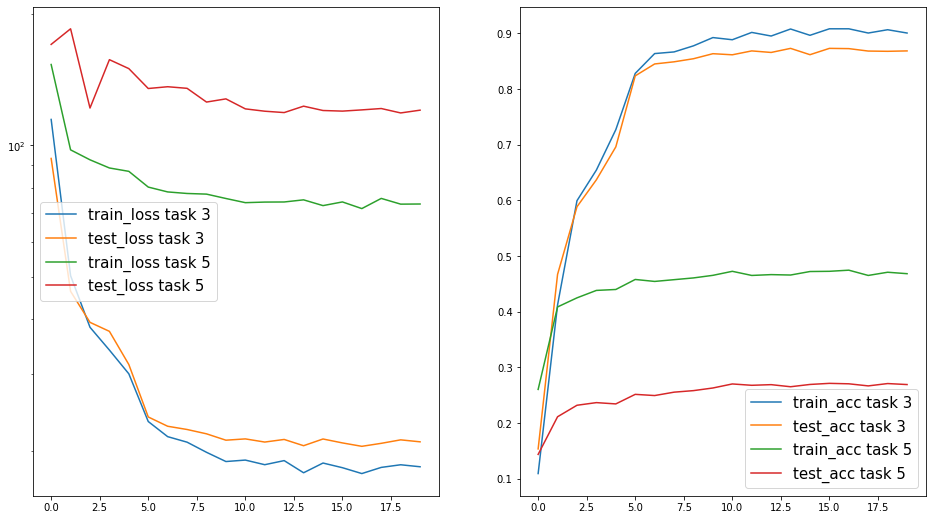

In [51]:
def plots(epoch_loss1, epoch_loss2, epoch_acc1, epoch_acc2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
    ax1.set_yscale('log')
    for phase in ('train', 'test'):
        ax1.plot(range(len(epoch_loss1[phase])), epoch_loss1[phase], label=(phase + '_loss task 3'))
        ax2.plot(range(len(epoch_acc1[phase])), epoch_acc1[phase], label=(phase + '_acc task 3'))    
    for phase in ('train', 'test'):
        ax1.plot(range(len(epoch_loss2[phase])), epoch_loss2[phase], label=(phase + '_loss task 5'))
        ax2.plot(range(len(epoch_acc2[phase])), epoch_acc2[phase], label=(phase + '_acc task 5'))
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})

plots(pure_epoch_loss, aug_epoch_loss, pure_epoch_acc, aug_epoch_acc)

### Summary
The performance of the model in task 5 went through a sharp decrease in accuracy and increase in loss. This might be caused by the image augmentation. Since there are random copies of image with applied transformation, there are more variety and so are more complex to analyze. This will influance the weight and therefore the overall performance of the model.